In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from numpy.random import default_rng
rng = default_rng()
%matplotlib inline

In [2]:
### Paramètres : 

S0 = 40  # Prix initial
K = 40  # Prix d'exercice
T = 1    # Maturité en années
r = 0.06 # Taux d'intérêt sans risque
sigma = 0.4 # Volatilité
N = 10  # Nombre de pas
dt = T / N  # Intervalle de temps
M = int(2**10) # Nombre de chemins MC

lambda_ = 0.0005 # paramètre de régularisation

In [3]:
def generate_black_scholes_paths(size_path, size_sample): 
    dt = T/size_path
    gaussien_inc = np.sqrt(dt)*rng.standard_normal(size=(size_path, size_sample))
    sample = np.zeros(shape=(size_path+1, size_sample))
    sample[0] = S0
    for n in range(1, size_path+1):
        sample[n] = sample[n-1] * np.exp((r - 0.5 * sigma**2)*dt + sigma*gaussien_inc[n-1])
    return sample




g = lambda x : np.maximum(K-x,0) # payoff function

R = lambda x : x-x*np.log(x) # Regularization function

In [7]:
optimal_price = 5.31

In [5]:
S_samples = generate_black_scholes_paths(N-1,M).T
data_train = generate_black_scholes_paths(N-1,M).T
data_test = generate_black_scholes_paths(N-1,M).T

In [107]:

import torch
from torch import nn
from torch import optim

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

creterio  = nn.MSELoss()


def Phi_NN() :

    class NeuralNetwork(nn.Module):
        def __init__(self):
            super().__init__()
            self.linear_relu_stack = nn.Sequential(
                nn.Linear(1, 21),
                nn.ReLU(),
                nn.Linear(21, 21),
                nn.ReLU(),
                nn.Linear(21, 21),
                nn.ReLU(),
                nn.Linear(21, 21),
                nn.ReLU(),
                nn.Linear(21, 21),
                nn.ReLU(),
                nn.Linear(21, 21),
                nn.ReLU(),
                nn.Linear(21, 1),
                nn.LeakyReLU(negative_slope=0.01)
            )

        def forward(self, x):
            out = self.linear_relu_stack(x)
            payoff = torch.max(K - x, torch.tensor(0.0))
            #payoff = (K-x)*torch.sigmoid(K - x)
            return out  +payoff
        

    # Define the optimizers and the networks : 

    Phi_functions = [NeuralNetwork().to(device) for n in range(1,N)]

    optimizers = [optim.Adam(Phi_functions[n-1].parameters(), lr=0.0001) for n in range(1,N)]

    return Phi_functions,optimizers


######################## 

def payoff_phi(n, x): 
    return np.exp(-r*n*T/N) * np.maximum(K-x, 0)


def calculate_price(Phi_functions,data_train):

    
    payoffs = np.empty_like(data_train)
    for n in range(0, N):
        payoffs[:,n] = payoff_phi(n, data_train[:,n])
    
    payoff_opt = payoffs[:,-1].copy() # Payoffs optimaux à l'instant t = N

    for n in range(N-1,0,-1):

        xx = torch.tensor(data_train[:, n], dtype=torch.float32, device=device).reshape(-1, 1)
        with torch.no_grad():
                continuation_function = Phi_functions[n-1](xx).cpu().numpy().flatten()

        stop_at_n = payoffs[:,n] >= continuation_function
        payoff_opt[stop_at_n] = payoffs[stop_at_n,n].copy() # Payoffs optimaux à l'instant t = n


    payoff_opt.mean()
    

    return payoff_opt.mean()



#############################


def train_evaluate(n_iteration,lambda_,Phi_functions,optimizers):


    Losses = []
    pi_values = np.ones_like(data_train)
    P = []

    for n in range(n_iteration): 

        S_samples = generate_black_scholes_paths(N-1,M).T
        #S_samples = data_train.copy()
        V_values = np.zeros_like(S_samples)
        V_values[:,-1] = g(S_samples[:,-1])


        print(f'{n+1} Iteration ...')
        

        total_loss = 0
        for l in range(N-2,-1,-1):
            
        
            #Calculate the TD-error :
            
            ## construct target vector
            X = S_samples[:,l]
            Y = g(S_samples[:,l])*pi_values[:,l]*dt + lambda_*R(pi_values[:,l])*dt+np.exp(-r*dt)*V_values[:,l+1]*(1-pi_values[:,l]*dt)

            xx = torch.tensor(X, dtype=torch.float32, device=device).reshape(-1, 1)
            yy = torch.tensor(Y, dtype=torch.float32, device=device)

            #print(f"Start training V_{l} ...")
            # entrainement "one step Gadient descent" :
            prediction = Phi_functions[l](xx)
            loss = creterio(prediction, yy.reshape(-1, 1))
            optimizers[l].zero_grad()
            loss.backward()
            optimizers[l].step()
            #print(f"model trained ! ...")
            total_loss+=loss

            # Calculate the new V using the updated parameters 
            with torch.no_grad():
                new_y =Phi_functions[l](xx).cpu().numpy().flatten()
            
            V_values[:,l] = new_y
        

        pi_values = np.ones_like(S_samples)
        pi_values[:,:-1] = np.exp(np.clip(-(V_values[:,:-1]-g(S_samples[:,:-1])) / lambda_, -5, 5))
        
        if n%1 == 0 :
            data_test = generate_black_scholes_paths(N-1,M).T
            price,_ = calculate_price(Phi_functions,data_test)
            relative_error = np.abs(optimal_price-price)/price

        
        P.append(relative_error)
        print(f"Epochs {n+1} finished !")
        print(f"TOTAL LOSS : {total_loss/N}")
        Losses.append((total_loss/N).detach().cpu().numpy())


    return P


Using cuda device


In [108]:



import torch
from torch import nn
from torch import optim

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

creterio  = nn.MSELoss()


def Phi_NN() :

    class NeuralNetwork(nn.Module):
        def __init__(self):
            super().__init__()
            self.linear_relu_stack = nn.Sequential(
                nn.Linear(1, 21),
                nn.ReLU(),
                nn.Linear(21, 21),
                nn.ReLU(),
                nn.Linear(21, 21),
                nn.ReLU(),
                nn.Linear(21, 21),
                nn.ReLU(),
                nn.Linear(21, 21),
                nn.ReLU(),
                nn.Linear(21, 21),
                nn.ReLU(),
                nn.Linear(21, 1),
                nn.LeakyReLU(negative_slope=0.01)
            )

        def forward(self, x):
            out = self.linear_relu_stack(x)
            payoff = torch.max(K - x, torch.tensor(0.0))
            #payoff = (K-x)*torch.sigmoid(K - x)
            return out  +payoff
        

    # Define the optimizers and the networks : 

    Phi_functions = [NeuralNetwork().to(device) for n in range(1,N)]

    optimizers = [optim.Adam(Phi_functions[n-1].parameters(), lr=0.0001) for n in range(1,N)]

    return Phi_functions,optimizers


######################## 

def payoff_phi(n, x): 
    return np.exp(-r*n*T/N) * np.maximum(K-x, 0)


def calculate_price(Phi_functions,data_train):

    
    payoffs = np.empty_like(data_train)
    for n in range(0, N):
        payoffs[:,n] = payoff_phi(n, data_train[:,n])
    
    payoff_opt = payoffs[:,-1].copy() # Payoffs optimaux à l'instant t = N

    for n in range(N-1,0,-1):

        xx = torch.tensor(data_train[:, n], dtype=torch.float32, device=device).reshape(-1, 1)
        with torch.no_grad():
                continuation_function = Phi_functions[n-1](xx).cpu().numpy().flatten()

        stop_at_n = payoffs[:,n] >= continuation_function
        payoff_opt[stop_at_n] = payoffs[stop_at_n,n].copy() # Payoffs optimaux à l'instant t = n


    payoff_opt.mean()
    

    return payoff_opt.mean(),np.array(payoff_opt)



#############################



Using cuda device


In [109]:
lambda_values = [100,10,1,0.1]
n_iteration = 1000

data_test = generate_black_scholes_paths(N-1,2**18).T
data_train = generate_black_scholes_paths(N-1,2**10).T

In [23]:
P = {}


for lambda_ in lambda_values : 

    Phi_functions,optimizers = Phi_NN()
    evaluation = train_evaluate(n_iteration,lambda_,Phi_functions,optimizers)
    P[lambda_] = evaluation

1 Iteration ...
Epochs 1 finished !
TOTAL LOSS : 106.43953704833984
2 Iteration ...
Epochs 2 finished !
TOTAL LOSS : 106.42756652832031
3 Iteration ...
Epochs 3 finished !
TOTAL LOSS : 106.41301727294922
4 Iteration ...
Epochs 4 finished !
TOTAL LOSS : 106.39808654785156
5 Iteration ...
Epochs 5 finished !
TOTAL LOSS : 106.38282775878906
6 Iteration ...
Epochs 6 finished !
TOTAL LOSS : 106.3676528930664
7 Iteration ...
Epochs 7 finished !
TOTAL LOSS : 106.35272216796875
8 Iteration ...
Epochs 8 finished !
TOTAL LOSS : 106.33778381347656
9 Iteration ...
Epochs 9 finished !
TOTAL LOSS : 106.32274627685547
10 Iteration ...
Epochs 10 finished !
TOTAL LOSS : 106.30769348144531
11 Iteration ...
Epochs 11 finished !
TOTAL LOSS : 106.2928237915039
12 Iteration ...
Epochs 12 finished !
TOTAL LOSS : 106.27815246582031
13 Iteration ...
Epochs 13 finished !
TOTAL LOSS : 106.26457977294922
14 Iteration ...
Epochs 14 finished !
TOTAL LOSS : 106.252197265625
15 Iteration ...
Epochs 15 finished !
TOTA

KeyboardInterrupt: 

In [8]:
def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


for lambda_ in lambda_values[1:-1] : 
    plt.plot(moving_average(P[lambda_][:100]),label = "$\lambda$="+str(lambda_))


plt.ylabel("Relative error")
plt.xlabel("Nb epochs")

plt.legend()

NameError: name 'P' is not defined

In [51]:
n_iteration

1000

In [114]:
Phi_functions,optimizers = Phi_NN()
evaluation = train_evaluate(n_iteration,0.05,Phi_functions,optimizers)
#P[lambda_] = evaluation

1 Iteration ...
Epochs 1 finished !
TOTAL LOSS : 6.4936723709106445
2 Iteration ...
Epochs 2 finished !
TOTAL LOSS : 6.8939642906188965
3 Iteration ...
Epochs 3 finished !
TOTAL LOSS : 6.799124240875244
4 Iteration ...
Epochs 4 finished !
TOTAL LOSS : 6.9804368019104
5 Iteration ...
Epochs 5 finished !
TOTAL LOSS : 6.475802898406982
6 Iteration ...
Epochs 6 finished !
TOTAL LOSS : 6.776081085205078
7 Iteration ...
Epochs 7 finished !
TOTAL LOSS : 6.995156288146973
8 Iteration ...
Epochs 8 finished !
TOTAL LOSS : 6.851934909820557
9 Iteration ...
Epochs 9 finished !
TOTAL LOSS : 6.676141262054443
10 Iteration ...
Epochs 10 finished !
TOTAL LOSS : 6.734472751617432
11 Iteration ...
Epochs 11 finished !
TOTAL LOSS : 6.954174041748047
12 Iteration ...
Epochs 12 finished !
TOTAL LOSS : 7.1309099197387695
13 Iteration ...
Epochs 13 finished !
TOTAL LOSS : 6.526664733886719
14 Iteration ...
Epochs 14 finished !
TOTAL LOSS : 6.701831340789795
15 Iteration ...
Epochs 15 finished !
TOTAL LOSS : 

In [17]:
len(Phi_functions)

9

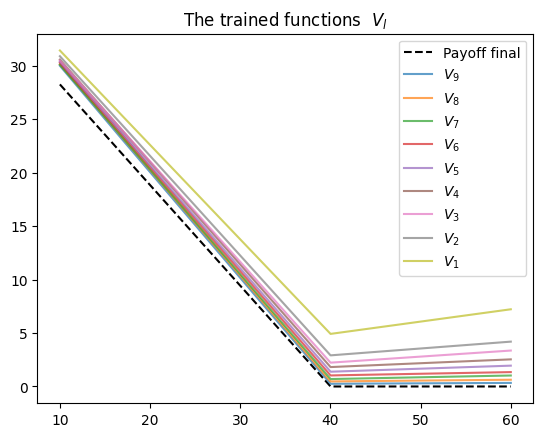

In [133]:
xx = np.linspace(10, 60, 10000).astype(np.float32)

plt.plot(xx, payoff_phi(N, xx), label="Payoff final", color='black', linestyle='dashed')

for l in range(N-2,-1,-1):
    # Plot Continuation Functions (C_n)
    xx_tensor = torch.tensor(xx).reshape(-1, 1).to("cuda" if torch.cuda.is_available() else "cpu")  
    Cn =Phi_functions[l](xx_tensor).detach().cpu().numpy().flatten()  
    plt.plot(xx, Cn, label=fr"$V_{l+1}$", alpha=0.7)
    plt.legend()
plt.title('The trained functions  $V_l$')
plt.savefig('trained_functions.png')

In [131]:
S_samples = generate_black_scholes_paths(N-1,2**18).T
price,list_price = calculate_price(Phi_functions,S_samples)
price

5.08375265389122

In [157]:
from scipy import stats

sample = list_price
mean = np.mean(sample)
var = np.var(sample, ddof=1)
alpha = 1 - 0.9 
quantile = stats.norm.ppf(1 - alpha/2)  # fonction quantile 
ci_size = quantile * np.sqrt(var / sample.size)
result = { 'mean': mean, 'var': var, 
            'lower': mean - ci_size, 
            'upper': mean + ci_size }

In [90]:
# lambda = 10
result

{'mean': 5.0913399574341085,
 'var': 43.9177558231073,
 'lower': 5.070049873887621,
 'upper': 5.112630040980596}

In [ ]:
# lambda = 1
result

{'mean': 5.10148516464195,
 'var': 43.9734188865723,
 'lower': 5.080181593429872,
 'upper': 5.122788735854028}

In [150]:
# lambda = 0.1
result

{'mean': 5.096274536606711,
 'var': 44.0883770027876,
 'lower': 5.07494313699317,
 'upper': 5.117605936220253}

In [159]:
# lambda = 0.01
result

{'mean': 5.094644287204089,
 'var': 43.912972822255,
 'lower': 5.0733553630208075,
 'upper': 5.11593321138737}